# Analyze microhh LES data

In this notebook, we will analyze data from the [microhh model](https://microhh.org/), simulating a case near the Southern Great Plains.

## Imports

In [2]:
#Load the usual libraries
import matplotlib.pyplot as plt
import xarray as xr
import scipy as sp
import numpy as np
import netCDF4 as nc

## Find the Data

In [3]:
# locate the folder where the data is stored
basedir = '/data/lasso/SGP/SGP_20160611/'
basename = 'SGP'
NC_arr = [10, 50, 80, 100, 200, 400, 800]


## Configure some helper functions

In [4]:
# Load a specific data set, and cycling through all groups to load all data
def load_data(fname):
    groups = [''] + list(nc.Dataset(fname).groups.keys())
    prof_dict = {}
    for group in groups:
        try:
            prof_dict[group] = xr.open_dataset(fname, group=group, decode_times=True)
            
        except KeyError:
            print(f'Group {group} not found in {fname}')
        except IOError:
            print(f'File {fname} not found')
        except:
            print('Unexpected error')
    prof = xr.merge(prof_dict.values())
    prof = prof.where(prof.apply(np.fabs)<1e10)

    return prof

# Cycle through all conditional samples and load the data; the conditional sample is added as a new dimension
def load_cond_data(dir, basename, cond_samps):
    prof_dict = {}
    for cond_samp in cond_samps:
        fname = dir + '/' + basename +'.' + cond_samp + '.0000000.nc'
        prof_dict[cond_samp] = load_data(fname).expand_dims(dim={'sample': [cond_samp]})
    prof = xr.merge(prof_dict.values())
    return prof
    
# Cycle through all different Number concentrations and load the data; the number concentration is added as a new dimension
def load_all_data(basedir, fname, NCs, cond_samps = ['default']):
    prof_array = {}
    for NC in NCs:
        NCstr = f'NC{NC:03}'
        print('Loading data for ' + NCstr)
        dir = basedir + '/' + NCstr + '/'
        prof_array[NCstr] = load_cond_data(dir, basename, cond_samps).expand_dims(dim={'NC': [NC]})

    return xr.merge(prof_array.values())



## Run through the Analysis

In [5]:
# Load the data for all number concentrations and conditional samples
cond_samps = ['default', 'ql', 'qlcore']
prof = load_all_data(basedir, basename, NC_arr, cond_samps)

#Slice the data for our area of interest, and resample to 30 min intervals
prof = prof.sel(time=slice("2016-06-11T12", "2016-06-12T02"),z=slice(0,4000), zh=slice(0,4000)).resample(time='0.5H').mean(dim='time')


Loading data for NC010
Loading data for NC050
Loading data for NC080
Loading data for NC100
Loading data for NC200
Loading data for NC400
Loading data for NC800


In [6]:
#Explore the data set. 
prof

<xarray.Dataset>
Dimensions:               (z: 107, zh: 108, zs: 4, zsh: 5, sample: 3, NC: 7,
                           time: 30, lev: 141)
Coordinates:
  * z                     (z) float32 10.0 21.0 33.0 ... 3.94e+03 3.98e+03
  * zh                    (zh) float32 0.0 15.5 27.0 ... 3.92e+03 3.96e+03 4e+03
  * zs                    (zs) float32 -1.89 -0.72 -0.21 -0.07
  * zsh                   (zsh) float32 -2.62 -1.16 -0.28 -0.14 0.0
  * sample                (sample) object 'default' 'ql' 'qlcore'
  * NC                    (NC) int64 10 50 80 100 200 400 800
  * time                  (time) datetime64[ns] 2016-06-11T12:00:00 ... 2016-...
Dimensions without coordinates: lev
Data variables: (12/141)
    p_rad                 (time, NC, sample, lev) float32 9.645e+04 ... 3.53
    iter                  (time, NC, sample) float64 1.738e+05 ... 2.484e+05
    area                  (time, NC, sample, z) float32 1.0 1.0 1.0 ... 0.0 0.0
    areah                 (time, NC, sample, zh) float32 1.0 1.0 1.0 ... 0.0 0.0
    u                     (time, NC, sample, z) float32 -0.09499 ... nan
    u_3                   (time, NC, sample, z) float32 -0.001409 ... nan
    ...                    ...
    sw_flux_dn_ref        (time, NC, sample, lev) float32 132.0 135.4 ... 0.6207
    sw_flux_dn_dir_ref    (time, NC, sample, lev) float32 105.2 109.1 ... 0.6207
    lw_flux_up_ref        (time, NC, sample, lev) float32 476.5 465.4 ... 282.1
    lw_flux_dn_ref        (time, NC, sample, lev) float32 386.1 359.6 ... 0.0
    sza                   (time, NC, sample) float32 1.39 1.39 ... 1.743 1.743
    sw_flux_dn_toa        (time, NC, sample) float32 236.5 236.5 ... 0.6207

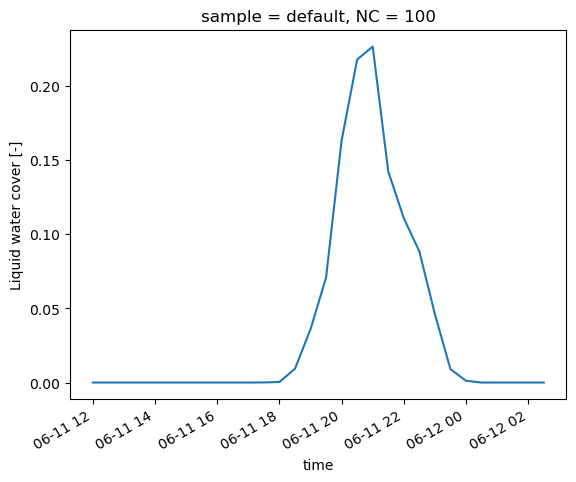

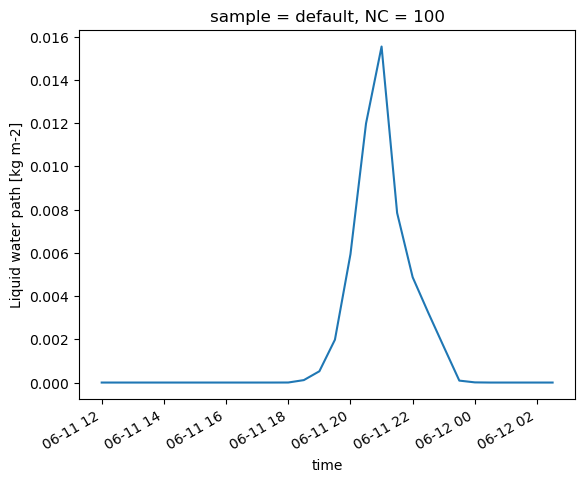

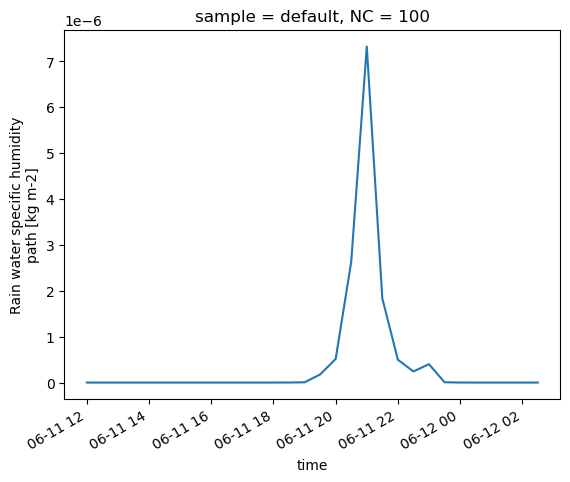

In [66]:
# We first explore a few basic statistics, such as overall cloud cover, LWP, cloud base height, and cloud top height
plt.figure()
prof.sel(NC=100, sample='default')['ql_cover'].plot()

plt.figure()
prof.sel(NC=100, sample='default')['ql_path'].plot()

plt.figure()
prof.sel(NC=100, sample='default')['qr_path'].plot()


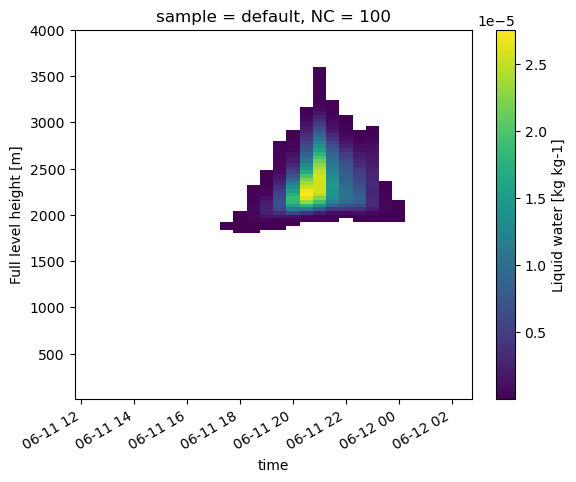

In [67]:
prof.sel(NC=100, sample='default')['ql'].where(prof.sel(NC=100, sample='default').ql>0).plot(x='time')

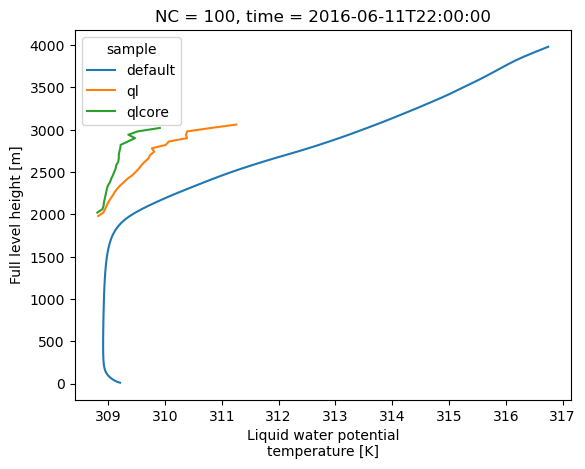

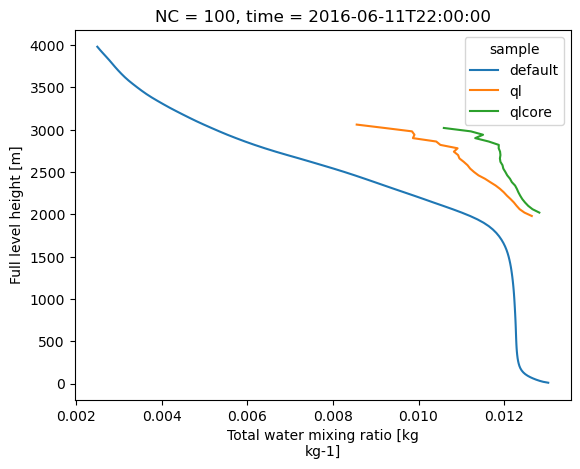

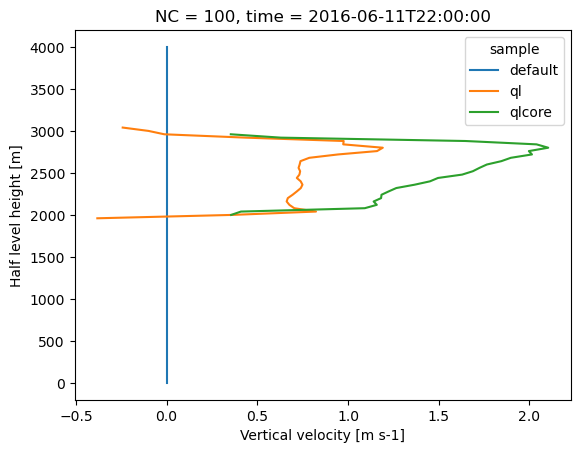

In [69]:
 #At 22:00, we are at peak cloudiness. Let's explore the vertical structure of the cloud at this time
 plt.figure()
 prof.sel(time='2016-06-11T22:00', NC=100).thl.plot.line(y='z', hue='sample')
 plt.figure()
 prof.sel(time='2016-06-11T22:00', NC=100).qt.plot.line(y='z', hue='sample')
 plt.figure()
 prof.sel(time='2016-06-11T22:00', NC=100).w.plot.line(y='zh', hue='sample')

In [ ]:
#Now for the moisture flux: Is this correct??
prof.sel(sample='default', NC=100, time="2016-06-11T22:00").qt_w.plot(y='zh')


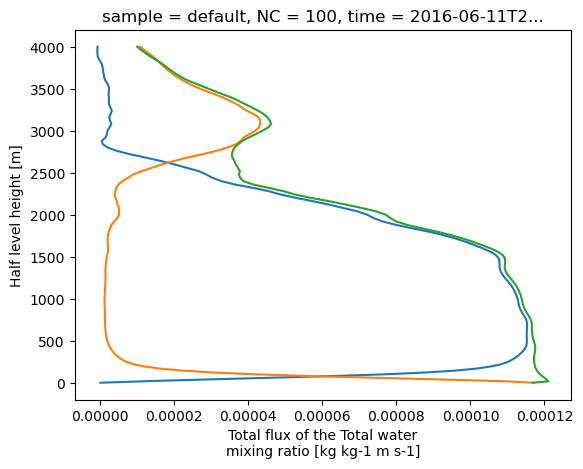

In [78]:
#We should not forget to add the Sub Filter Scale Fluxes; the MicroHH output has that automatically as '_flux'. What do you notice about the following plot?
prof.sel(sample='default', NC=100, time="2016-06-11T22:00").qt_w.plot(y='zh')
prof.sel(sample='default', NC=100, time="2016-06-11T22:00").qt_diff.plot(y='zh')
prof.sel(sample='default', NC=100, time="2016-06-11T22:00").qt_flux.plot(y='zh')

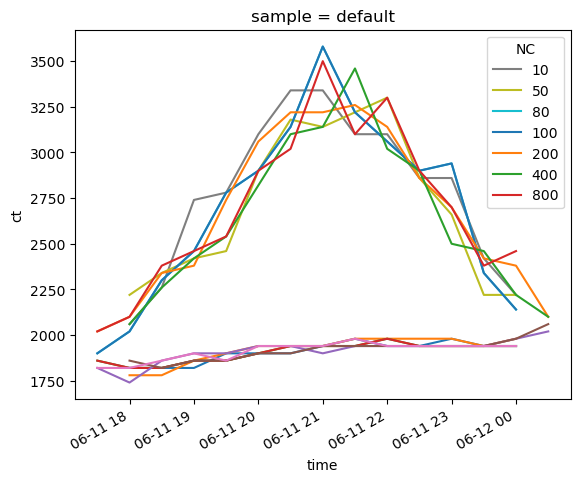

In [75]:
# Calculate the cloud base and cloud top heights, that is, the first and last point where the liquid water content is larger than zero
prof['cb'] = (prof['ql']>0).idxmax(dim='z')
prof['cb'] = prof.cb.where(prof.cb>prof.z[0]) # remove cloud base if they are at the lowest level 

prof['ct'] = (prof['ql']>0).isel(z=slice(None, None, -1)).idxmax(dim='z')
prof['ct'] = prof.ct.where(prof.ct<prof.z[-1]) # remove cloud top if they are at the highest level

# Plot them
prof.sel(sample='default')['cb'].plot.line(hue='NC')
prof.sel(sample='default')['ct'].plot.line(hue='NC')
# prof.sel(sample='default')['ct'].plot()

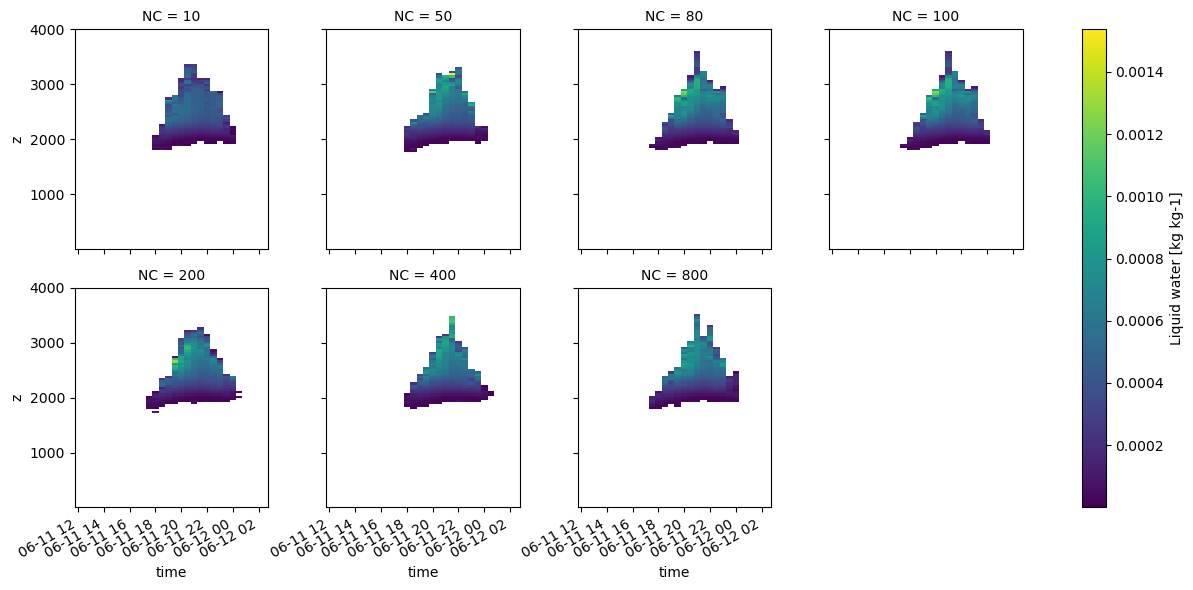

In [44]:
prof.sel(sample='ql').ql.plot(x='time', col='NC', col_wrap=4)

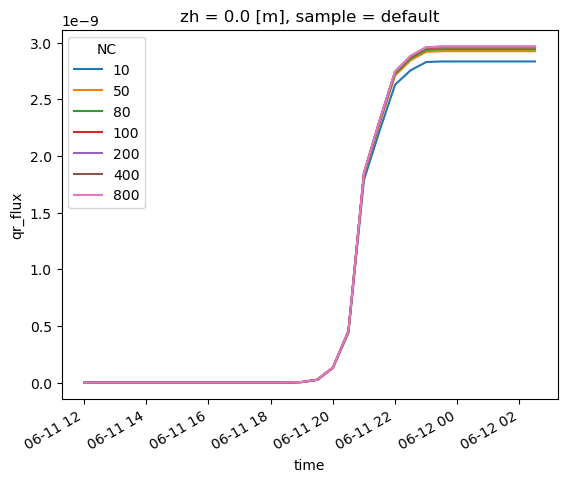

In [62]:
(-prof.sel(sample='default').qr_flux.sel(zh=0).cumsum()).plot(x='time', hue='NC')

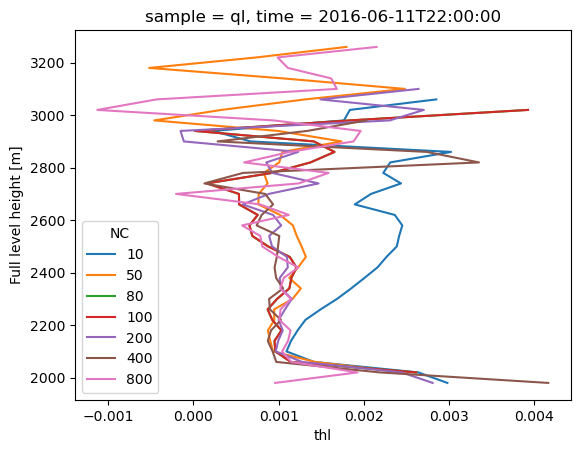

In [76]:
#Bulk entrainment is defined as \epsilon = -\frac{d\theta_l}{dz} / (\phi_c - \phi_e), where \phi_c is the cloud property, and \phi_e are the environmental properties.
#We will use the cloud potential temperature as the cloud property, and the environmental potential temperature as the environmental property
epsilon = prof.sel(time='2016-06-11T22:00', sample='ql').thl.differentiate(coord='z') / (prof.sel(time='2016-06-11T22:00', sample='default').thl - prof.sel(time='2016-06-11T22:00', sample='ql').thl)
epsilon.plot.line(y='z', hue='NC')

In [47]:
prof

<xarray.Dataset>
Dimensions:               (z: 107, zh: 108, zs: 4, zsh: 5, sample: 3, NC: 8,
                           time: 30, lev: 141)
Coordinates:
  * z                     (z) float32 10.0 21.0 33.0 ... 3.94e+03 3.98e+03
  * zh                    (zh) float32 0.0 15.5 27.0 ... 3.92e+03 3.96e+03 4e+03
  * zs                    (zs) float32 -1.89 -0.72 -0.21 -0.07
  * zsh                   (zsh) float32 -2.62 -1.16 -0.28 -0.14 0.0
  * sample                (sample) object 'default' 'ql' 'qlcore'
  * NC                    (NC) int64 10 50 80 100 200 400 600 800
  * time                  (time) datetime64[ns] 2016-06-11T12:00:00 ... 2016-...
Dimensions without coordinates: lev
Data variables: (12/141)
    p_rad                 (time, NC, sample, lev) float32 9.645e+04 ... 3.53
    iter                  (time, NC, sample) float64 1.738e+05 ... 2.484e+05
    area                  (time, NC, sample, z) float32 1.0 1.0 1.0 ... 0.0 0.0
    areah                 (time, NC, sample, zh) float32 1.0 1.0 1.0 ... 0.0 0.0
    u                     (time, NC, sample, z) float32 -0.09499 ... nan
    u_3                   (time, NC, sample, z) float32 -0.001409 ... nan
    ...                    ...
    sw_flux_dn_ref        (time, NC, sample, lev) float32 132.0 135.4 ... 0.6207
    sw_flux_dn_dir_ref    (time, NC, sample, lev) float32 105.2 109.1 ... 0.6207
    lw_flux_up_ref        (time, NC, sample, lev) float32 476.5 465.4 ... 282.1
    lw_flux_dn_ref        (time, NC, sample, lev) float32 386.1 359.6 ... 0.0
    sza                   (time, NC, sample) float32 1.39 1.39 ... 1.743 1.743
    sw_flux_dn_toa        (time, NC, sample) float32 236.5 236.5 ... 0.6207

In [54]:
prof.sel(sample='default', NC=100, time="2016-06-11T22:00")[['qt_w', 'qt_diff']]


<xarray.Dataset>
Dimensions:  (zh: 108)
Coordinates:
  * zh       (zh) float32 0.0 15.5 27.0 39.5 ... 3.92e+03 3.96e+03 4e+03
    sample   <U7 'default'
    NC       int64 100
    time     datetime64[ns] 2016-06-11T22:00:00
Data variables:
    qt_w     (zh) float32 0.0 1.063e-05 1.896e-05 ... -8.208e-07 -7.689e-07
    qt_diff  (zh) float32 0.0001169 0.0001104 0.0001019 ... 1.185e-05 1.072e-05

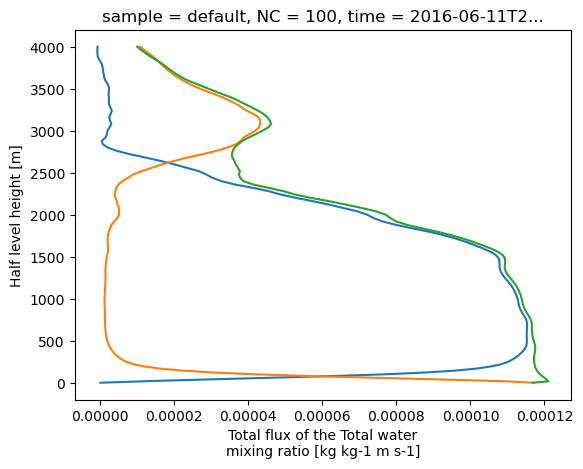

In [50]:
prof.sel(sample='default', NC=100, time="2016-06-11T22:00").qt_w.plot(y='zh')
prof.sel(sample='default', NC=100, time="2016-06-11T22:00").qt_diff.plot(y='zh')
prof.sel(sample='default', NC=100, time="2016-06-11T22:00").qt_flux.plot(y='zh')

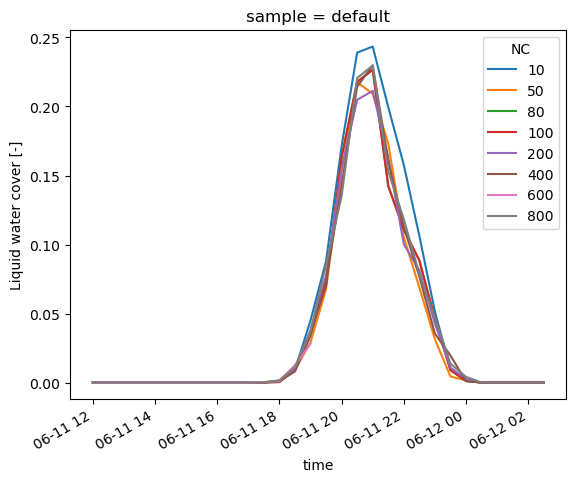

In [59]:
prof.sel(sample='default').ql_cover.plot(x='time', hue='NC')


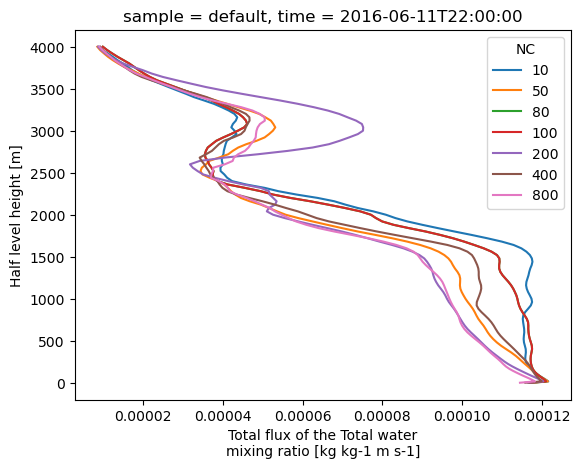

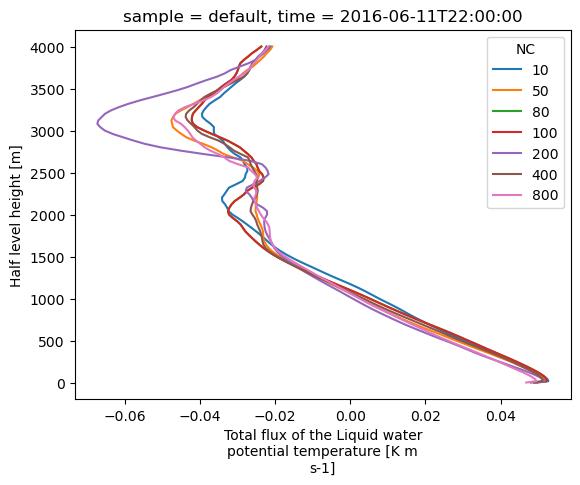

In [79]:
plt.figure()
prof.sel(sample='default', time="2016-06-11T22:00").qt_flux.plot(y='zh', hue='NC')

plt.figure()
prof.sel(sample='default', time="2016-06-11T22:00").thl_flux.plot(y='zh', hue='NC')